In [2]:
import os
import sys
from gurobipy import *
import pandas as pd
import numpy as np
module_path = os.path.abspath("..")
sys.path.append(module_path)
import itertools
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from module.modele1 import init_model,Taches
from module.utils1 import (
    read_sillon,
    init_t_a,
    init_t_d,
    init_dict_correspondance,
    base_time,
    init_limites_voies,
    dernier_depart
)

In [13]:
# Charger le fichier Excel

id_file = 2

if id_file == 0:
    file = "mini_instance.xlsx"
elif id_file == 1:    
    file = "instance_WPY_realiste_jalon1.xlsx"
elif id_file == 2:
    file = "instance_WPY_realiste_jalon2.xlsx"
elif id_file == 3:
    file = "instance_WPY_simple.xlsx"
else:
    raise ValueError(f"Erreur : '{id_file}' n'est pas une valeur acceptable. Choisissez parmi 0, 1, 2 et 3.")

# Lire les feuilles "Sillons arrivée" et "Sillons départ"
df_sillons_arr, df_sillons_dep = read_sillon(file)

# Dictionnaires pour stocker les temps d'arrivée et de départ en minutes :
# Traitement des arrivées
t_a = init_t_a(df_sillons_arr, id_file, print_bool=True)

t_d = init_t_d(df_sillons_dep, id_file, print_bool=True)

#Initialisation de l'intervalle de temps étudié
t_min=0
t_max=int(dernier_depart(df_sillons_dep,base_time(id_file))) #en quinzaine de minutes
print(t_max//15+1)

# Vérification finale
print("Vérification du contenu final de t_a :")
for key, value in t_a.items():
    print(f"Le train {key} arrive en gare de Woippy au bout de {value} minutes")

print("Vérification du contenu final de t_d :")
for key, value in t_d.items():
    print(f"Le train {key} part de la gare de Woippy au bout de {value} minutes")

909
Vérification du contenu final de t_a :
Le train 412202_08 arrive en gare de Woippy au bout de 1248 minutes
Le train 431018_08 arrive en gare de Woippy au bout de 801 minutes
Le train 431246_08 arrive en gare de Woippy au bout de 664 minutes
Le train 44951_08 arrive en gare de Woippy au bout de 1130 minutes
Le train 450237_08 arrive en gare de Woippy au bout de 707 minutes
Le train 489016_08 arrive en gare de Woippy au bout de 1415 minutes
Le train 54234_08 arrive en gare de Woippy au bout de 1321 minutes
Le train 55390_08 arrive en gare de Woippy au bout de 1429 minutes
Le train 56135_08 arrive en gare de Woippy au bout de 1288 minutes
Le train 412023_09 arrive en gare de Woippy au bout de 1567 minutes
Le train 41264_09 arrive en gare de Woippy au bout de 2793 minutes
Le train 431802_09 arrive en gare de Woippy au bout de 1620 minutes
Le train 44222_09 arrive en gare de Woippy au bout de 2533 minutes
Le train 44250_09 arrive en gare de Woippy au bout de 2058 minutes
Le train 44865

In [4]:
df_correspondance = pd.read_excel(file, sheet_name="Correspondances")

D = init_dict_correspondance(df_correspondance, id_file)

print(D)

{'54003_10': ['431802_09', '56135_08', '44865_09', '44250_09', '47262_09'], '54003_11': ['431802_10', '412202_10', '412202_10', '412202_10', '47262_10', '431020_10', '44250_10', '44222_10', '44228_10', '47214_10'], '54003_12': ['431802_11', '412202_11', '412202_11', '56135_11', '412202_11', '56135_11', '56135_11', '55396_11', '47262_11', '44250_11', '44222_11', '44865_11', '47822_11', '47262_11'], '54003_15': ['431802_12', '58706_13', '58706_12', '56730_14', '58706_12', '412202_12', '431802_13', '431802_13', '58706_12'], '400014_10': ['58706_09', '58706_09', '54234_09'], '400110_09': ['489016_08', '54234_08', '54234_08', '54234_08'], '450226_15': ['412023_13', '41230_13', '56730_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '412023_13', '450235_13', '412023_13', '450235_13', '412023_13'], '54003_14': ['58706_13', '58706_13', '58706_13', '412202_12', '58706_13', '58706_13', '58706_13', 

In [8]:
model,t_arr,t_dep, is_present = init_model(
    liste_id_train_arrivee = t_a.keys(),
    t_a = t_a,
    liste_id_train_depart = t_d.keys(),
    t_d = t_d,
    dict_correspondances = D,
    file=file,
    id_file = id_file,
    limites_voies=init_limites_voies(file),
    tempsMax=int(t_max//15+1),
    tempsMin=0
)


Contrainte assurant la succession des tâches sur les trains d'arrivée: 100%|██████████| 111/111 [00:00<?, ?it/s]
Contrainte assurant la succession des tâches sur les trains de départ: 100%|██████████| 106/106 [00:00<00:00, 32419.15it/s]
Contrainte assurant qu'il n'y a qu'un train niveau de la machine DEB: 100%|██████████| 111/111 [00:00<00:00, 111.99it/s]
Contrainte assurant qu'il n'y a qu'un train niveau des machines FOR et DEG: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]
Contrainte de fermeture du Chantier FOR: 100%|██████████| 106/106 [00:00<00:00, 864.87it/s]
Contrainte assurant la succession des tâches entre les chantiers de REC et FOR: 100%|██████████| 106/106 [00:00<00:00, 8268.02it/s]
Contrainte relative au nombre de voies des chantiers: 100%|██████████| 910/910 [00:00<00:00, 3330.86it/s]


In [9]:
model.optimize()

if model.status == GRB.INFEASIBLE:
    print("Le modèle n'a pas de solution")
elif model.status == GRB.UNBOUNDED:
    print("Le modèle est non borné")
else:
    print("Ca marche !")
    for (m, n), var in t_arr.items():
        print(f"Tâche {m} - Train {n} : {15*var.x}")
    for (m, n), var in t_dep.items():
        print(f"Tâche {m} - Train {n} : {15*var.x}")
    print('La valeur objectif est :', model.objVal)

Ca marche !
Tâche 1 - Train 412202_08 : 1260.0
Tâche 1 - Train 431018_08 : 810.0
Tâche 1 - Train 431246_08 : 675.0
Tâche 1 - Train 44951_08 : 1140.0
Tâche 1 - Train 450237_08 : 720.0
Tâche 1 - Train 489016_08 : 1425.0
Tâche 1 - Train 54234_08 : 1335.0
Tâche 1 - Train 55390_08 : 1440.0
Tâche 1 - Train 56135_08 : 1290.0
Tâche 1 - Train 412023_09 : 1575.0
Tâche 1 - Train 41264_09 : 2805.0
Tâche 1 - Train 431802_09 : 1620.0
Tâche 1 - Train 44222_09 : 2535.0
Tâche 1 - Train 44250_09 : 2070.0
Tâche 1 - Train 44865_09 : 2430.0
Tâche 1 - Train 450237_09 : 2160.0
Tâche 1 - Train 471003_09 : 2205.0
Tâche 1 - Train 47262_09 : 1995.0
Tâche 1 - Train 489026_09 : 2025.0
Tâche 1 - Train 54234_09 : 2775.0
Tâche 1 - Train 55390_09 : 2880.0
Tâche 1 - Train 55398_09 : 1680.0
Tâche 1 - Train 56135_09 : 2730.0
Tâche 1 - Train 56730_09 : 1605.0
Tâche 1 - Train 58706_09 : 2715.0
Tâche 1 - Train 412023_10 : 3015.0
Tâche 1 - Train 412202_10 : 4140.0
Tâche 1 - Train 41264_10 : 4245.0
Tâche 1 - Train 431020_10 :

In [10]:
# Liste ordonnée des machines
ORDERED_MACHINES = ["arr_1", "arr_2", "arr_3",
                        "dep_1", "dep_2", "dep_3", "dep_4"]

# Données fournies sous forme de liste de dictionnaires
tasks = [
        {"Train": n_arr,
         "Start": base_time(1) + datetime.timedelta(minutes=15*var_arr.X),
         "Finish": base_time(1) + datetime.timedelta(minutes=15*var_arr.X + Taches.T_ARR[m_arr]),
         "Machine": f"arr_{m_arr}",
         "Tâches": f"arr_{m_arr}"}
        for (m_arr, n_arr), var_arr in t_arr.items()
    ] + [
        {"Train": n_dep,
         "Start": base_time(1) + datetime.timedelta(minutes=15*var_dep.X),
         "Finish": base_time(1) + datetime.timedelta(minutes=15*var_dep.X + Taches.T_DEP[m_dep]),
         "Machine": f"dep_{m_dep}",
         "Tâches": f"dep_{m_dep}"}
        for (m_dep, n_dep), var_dep in t_dep.items()
    ]

# Construction du DataFrame pour la visualisation
gantt_df = pd.DataFrame(tasks)

# Regroupement des ressources par machine
resource_per_machine = {}
for task in tasks:
    resource_per_machine.setdefault(
        task["Machine"], set()).add(task["Tâches"])

sorted_resources = list(itertools.chain.from_iterable(
    [sorted(resource_per_machine[machine]) for machine in ORDERED_MACHINES]
))

fig = px.timeline(gantt_df, x_start="Start",
                    x_end="Finish", y="Tâches", color="Train")
fig.update_layout(xaxis=dict(title='Temps',
                    tickformat='%d/%m/%y %H:%M'))
fig.update_yaxes(categoryorder="array",
                    categoryarray=sorted_resources[::-1])
fig.show()

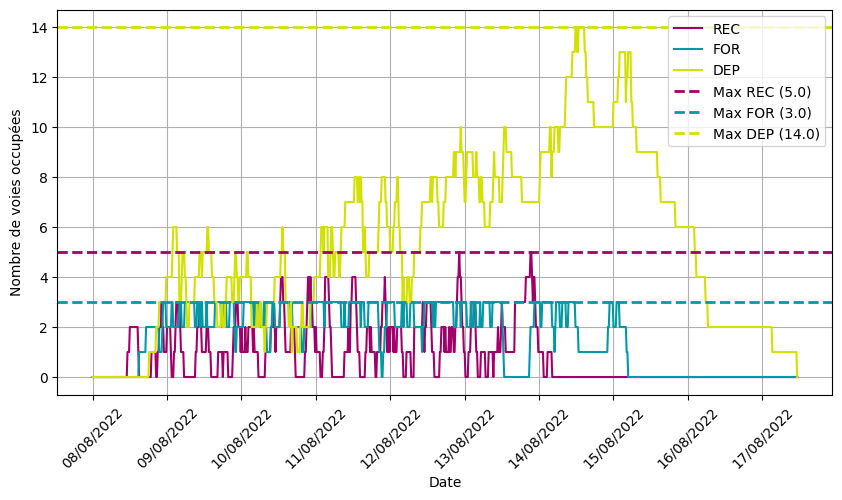

In [18]:
# Définition de l'axe des x (temps en minutes)
x = list(range(t_max//15+2))

# Correction du format de la date de référence
ref_date = datetime.datetime.strptime("08/08/2022", "%d/%m/%Y")

# Conversion des temps en dates au format "dd/mm/yyyy/HH/MM"
x_date = [ref_date + datetime.timedelta(minutes=15*t) for t in x]

# Calcul des valeurs y pour chaque catégorie
y_REC = np.array([quicksum(is_present['REC'][(id_train, t)].X for id_train in t_a.keys()).getValue() for t in x])
y_FOR = np.array([quicksum(is_present['FOR'][(id_train, t)].X for id_train in t_d.keys()).getValue() for t in x])
y_DEP = np.array([quicksum(is_present['DEP'][(id_train, t)].X for id_train in t_d.keys()).getValue() for t in x])

# Calcul des valeurs maximales
max_REC = max(y_REC)
max_FOR = max(y_FOR)
max_DEP = max(y_DEP)

# Tracé des courbes
plt.figure(figsize=(10, 5))
plt.plot(x_date, y_REC, label="REC", color='#a1006b')
plt.plot(x_date, y_FOR, label="FOR", color='#009aa6')
plt.plot(x_date, y_DEP, label="DEP", color='#d2e100')

# Ajout des lignes horizontales aux valeurs max
plt.axhline(y=max_REC, color='#a1006b', linestyle='--', linewidth=2, label=f"Max REC ({max_REC})")
plt.axhline(y=max_FOR, color='#009aa6', linestyle='--', linewidth=2, label=f"Max FOR ({max_FOR})")
plt.axhline(y=max_DEP, color='#d2e100', linestyle='--', linewidth=2, label=f"Max DEP ({max_DEP})")

# Étiquettes et légende
plt.xlabel("Date")
plt.ylabel("Nombre de voies occupées")
plt.legend()
plt.grid(True)

# Appliquer le format de date "jj/mm/aaaa"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))

# Espacer les ticks de l'axe X (ajustable selon le nombre de points)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Affiche une date par jour


# Optionnel : masquer les ticks de l'axe x si on ne remplace pas par les dates
plt.xticks(rotation=45)  

plt.show()
